In [ ]:
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn

In [ ]:
!mkdir ./datasets

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip -P ./datasets/

--2024-04-29 11:22:24--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.14.44, 13.224.14.120, 13.224.14.23, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.14.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘./datasets/data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2024-04-29 11:22:24 (52.7 MB/s) - ‘./datasets/data.zip’ saved [2882130/2882130]



In [ ]:
!unzip ./datasets/data.zip -d ./datasets/

Archive:  ./datasets/data.zip
   creating: ./datasets/data/
  inflating: ./datasets/data/eng-fra.txt  
   creating: ./datasets/data/names/
  inflating: ./datasets/data/names/Arabic.txt  
  inflating: ./datasets/data/names/Chinese.txt  
  inflating: ./datasets/data/names/Czech.txt  
  inflating: ./datasets/data/names/Dutch.txt  
  inflating: ./datasets/data/names/English.txt  
  inflating: ./datasets/data/names/French.txt  
  inflating: ./datasets/data/names/German.txt  
  inflating: ./datasets/data/names/Greek.txt  
  inflating: ./datasets/data/names/Irish.txt  
  inflating: ./datasets/data/names/Italian.txt  
  inflating: ./datasets/data/names/Japanese.txt  
  inflating: ./datasets/data/names/Korean.txt  
  inflating: ./datasets/data/names/Polish.txt  
  inflating: ./datasets/data/names/Portuguese.txt  
  inflating: ./datasets/data/names/Russian.txt  
  inflating: ./datasets/data/names/Scottish.txt  
  inflating: ./datasets/data/names/Spanish.txt  
  inflating: ./datasets/data/names/V

In [ ]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

In [ ]:
# Turn a Unicode string to plain ASCII,
# thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [ ]:
# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

In [ ]:
def findFiles(path): return glob.glob(path)

In [ ]:
# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('./datasets/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

In [ ]:
n_categories = len(all_categories)

In [ ]:
if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

In [ ]:
# category tensor is a one-hot vector, like letter input
print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Spanish', 'Greek', 'Chinese', 'Irish', 'French', 'Russian', 'Czech', 'Japanese', 'Vietnamese', 'English', 'Italian', 'Dutch', 'Korean', 'Arabic', 'German', 'Scottish', 'Portuguese', 'Polish']
O'Neal


In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size

    # input_combined to hidden
    self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
    # input_combined to output
    self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
    # output_combined to output
    self.o2o = nn.Linear(hidden_size + output_size, output_size)
    # dropout randomly zero parts of its input with probability 0.1
    self.dropout = nn.Dropout(0.1)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, category, input, hidden):
    # input_combined = [category, input, hidden]
    input_combined = torch.cat((category, input, hidden), 1)
    # input to hidden
    hidden = self.i2h(input_combined)
    # input to output
    output = self.i2o(input_combined)
    # output_combined = [hidden, output]
    output_combined = torch.cat((hidden, output), 1)
    # output_combined to output
    output = self.o2o(output_combined)
    # dropout some parts of the output
    output = self.dropout(output)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
      return torch.zeros(1, self.hidden_size)

# Data preparation

For each timestep:
*   the inputs of the network will be (category, current letter, hidden state)
*   the outputs will be (next letter, next hidden state)

For each training set requires:


*   the category
*   a set of input letters

*   a set of output/target letters

Since we are predicting the next letter from the current letter for each timestep, the letter pairs are groups of consecutive letters from the line.

example: "ABCD\<EOS>"
("A","B"), ("B", "C"), ("C", "D"), ("D", "EOS")





Category tensor is a one-hot tensor of size <1 x n_categories>



In [ ]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [ ]:
# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [ ]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

In [ ]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

In [ ]:
# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [ ]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

# Training

RNN is making a prediction at every step, so it needs to calculate the loss at every step

In [ ]:
# rnn model
rnn = RNN(n_letters, 128, n_letters)
print(rnn)

RNN(
  (i2h): Linear(in_features=205, out_features=128, bias=True)
  (i2o): Linear(in_features=205, out_features=59, bias=True)
  (o2o): Linear(in_features=187, out_features=59, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
# loss function
criterion = nn.NLLLoss()
# init learning rate
learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
  # one new dim as last
  target_line_tensor.unsqueeze_(-1)
  # init hidden
  hidden = rnn.initHidden()
  # zero the parameter gradients
  rnn.zero_grad()
  # init loss = 0
  loss = torch.Tensor([0])

  for i in range(input_line_tensor.size(0)):
    # rnn takes category, input letter, output letter
    output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
    # loss between prediction and target
    l = criterion(output, target_line_tensor[i])
    loss += l

  # backpropagation
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item() / input_line_tensor.size(0)

In [ ]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
# init params
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

In [ ]:
start = time.time() # start training time

In [ ]:
for iter in range(1, n_iters + 1):
  # training
  output, loss = train(*randomTrainingExample())
  # compute loss
  total_loss += loss
  # print loss
  if iter % print_every == 0:
      print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
  # store average loss
  if iter % plot_every == 0:
      all_losses.append(total_loss / plot_every)
      total_loss = 0

0m 17s (5000 5%) 2.8773
0m 31s (10000 10%) 2.7370
0m 46s (15000 15%) 2.5729
1m 2s (20000 20%) 2.6198
1m 19s (25000 25%) 2.7154
1m 34s (30000 30%) 3.4417
1m 49s (35000 35%) 2.3442
2m 9s (40000 40%) 3.1811
2m 23s (45000 45%) 2.1088
2m 39s (50000 50%) 2.8708
2m 54s (55000 55%) 2.5947
3m 8s (60000 60%) 2.2667
3m 26s (65000 65%) 2.2199
3m 48s (70000 70%) 1.3348
4m 2s (75000 75%) 2.4543
4m 17s (80000 80%) 1.5544
4m 31s (85000 85%) 2.7941
4m 45s (90000 90%) 2.3146
5m 0s (95000 95%) 2.2267
5m 14s (100000 100%) 2.0362


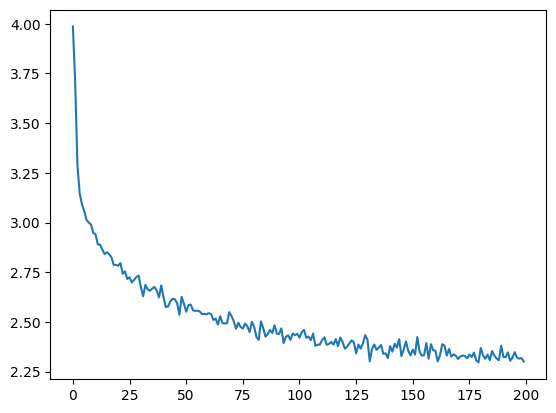

In [ ]:
plt.figure()
plt.plot(all_losses)

In [ ]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
  with torch.no_grad():  # no need to track history in sampling
    category_tensor = categoryTensor(category)
    input = inputTensor(start_letter)
    hidden = rnn.initHidden()

    output_name = start_letter

    for i in range(max_length):
      output, hidden = rnn(category_tensor, input[0], hidden)
      topv, topi = output.topk(1)
      topi = topi[0][0]
      if topi == n_letters - 1:
        break
      else:
        letter = all_letters[topi]
        output_name += letter
      input = inputTensor(letter)

    return output_name

In [ ]:
# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
  for start_letter in start_letters:
    print(sample(category, start_letter))

In [ ]:
samples('German','GER')

Gangherr
Eren
Ronger


In [ ]:
samples('Japanese','JPN')

Janga
Panakami
Naka
